# This is notebook mainly shows the methods about halos rendering 

In [12]:
from slsim.Pipelines.halos_pipeline import HalosSkyPyPipeline
from slsim.Halos.halos_lens import HalosLens
import numpy as np
from astropy.cosmology import default_cosmology, FlatLambdaCDM
import matplotlib.pyplot as plt
from slsim.Halos.halos_plus_glass import (
    read_glass_data,
    skyarea_form_n,
    generate_samples_from_glass,
    halos_plus_glass,
    convergence_mean_0,
    run_certain_redshift_lensext_kde_by_multiprocessing,
)
import os
from slsim.Halos.halos_plus_glass import run_halos_without_kde_by_multiprocessing
import seaborn as sns
import pandas as pd

# Initializing the Halos Pipeline
Initializes the 'HalosSkyPyPipeline' with specified parameters like sky area and mass range, preparing the pipeline for halo generation and mass sheet correction calculations.
Shows the halos generated by the pipeline and plots a scatter plot of z vs. log10(mass) for the halos.

        z                 mass       
------------------ ------------------
 2.798507680474822  102761431770.0902
0.6956744639451892 105188917678.39252
1.5925873294806887 121045597868.67287
3.1090248533481857 363460813626.10394
2.4147654418123534  475614944694.0358
0.8154716925940096  150534109748.6173
 3.158207685178817  422789845077.2866
2.5491461434419134 113211474910.97336
3.6625745470859226  988384029024.9987
 2.510679063945849   365714736868.579
               ...                ...
 0.870371260831854 188126619416.34128
2.0160000308644053 257169165624.52277
  2.34394763073052 120540142433.05727
 4.972093134908517 132601372008.02977
 1.985384801001785  162912860221.4075
1.8125571804397167  715769900403.7799
 1.274196229515282 116735894034.57767
 4.649679453979283 135801163036.45396
 2.905123151326381  484024991621.0943
1.2904741682096719 115367216856.72496
1.1692768443538606  249639764896.9908
Length = 156 rows


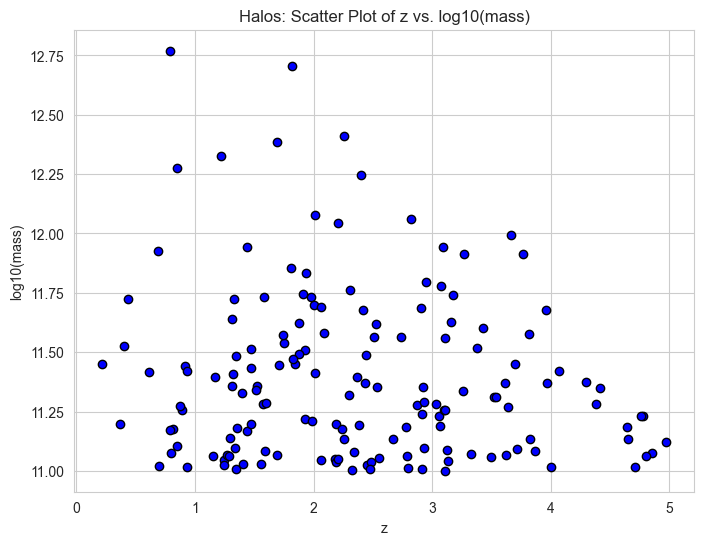

In [13]:
pipeline = HalosSkyPyPipeline(
    sky_area=0.00036,  # in square degrees
    m_max="1.0E+16",  # in solar masses
    m_min="1.0E+11",
    z_max=5.00,
)
halos = pipeline.halos
mass_sheet_correction = (
    pipeline.mass_sheet_correction
)  # calculating a negative convergence for
# mass sheet based on the average convergence of multiple halos rendering

print(halos)
z_halos = halos["z"]
mass_halos = halos["mass"]

log_mass = np.log10(mass_halos)
plt.figure(figsize=(8, 6))
plt.scatter(z_halos, log_mass, c="blue", marker="o", edgecolors="black")
plt.title("Halos: Scatter Plot of z vs. log10(mass)")
plt.xlabel("z")
plt.ylabel("log10(mass)")
plt.grid(True)

# Plotting the convergence map for the halos
## with or without mass sheet correction

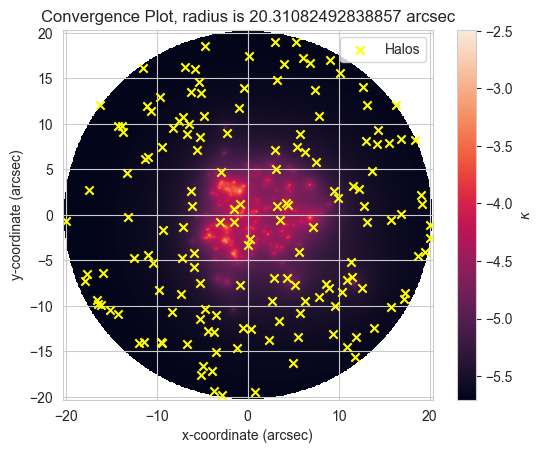

In [14]:
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

# Instantiate the HalosLens class with the halo list computed above and a defined sky area
halos_lens = HalosLens(
    halos_list=halos,
    mass_correction_list=mass_sheet_correction,
    mass_sheet=True,
    sky_area=0.0001,
    cosmo=cosmo,
    samples_number=1000,
)
halos_lens.plot_convergence(
    diff=0.01,
)

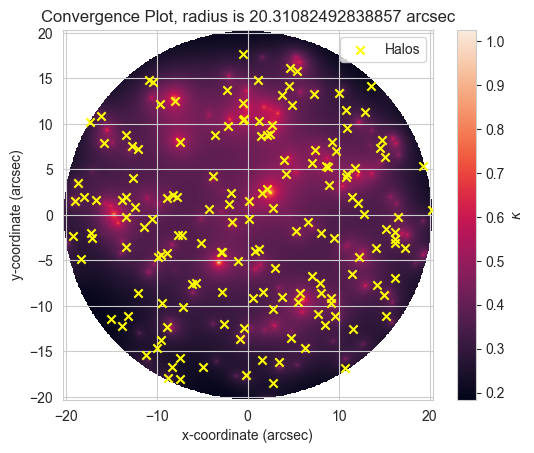

In [15]:
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

# Instantiate the HalosLens class with the halo list computed above and a defined sky area
halos_lens = HalosLens(
    halos_list=halos,
    mass_correction_list=None,  # No mass sheet correction
    mass_sheet=False,  # No mass sheet correction
    sky_area=0.0001,
    cosmo=cosmo,
    samples_number=1000,
)
halos_lens.plot_convergence(diff=0.01)

## Render the joint contribution of external convergence and shears from halos rendering

In [16]:
halos_k, halos_g = run_halos_without_kde_by_multiprocessing(
    n_iterations=100,
    sky_area=0.00036,
    samples_number=100,
    cosmo=cosmo,
    z_max=5.0,
)

kappa_random_halos = convergence_mean_0(halos_k)
gamma_random_halos = halos_g

The 100 halo-lists took 11.713665962219238 seconds to run


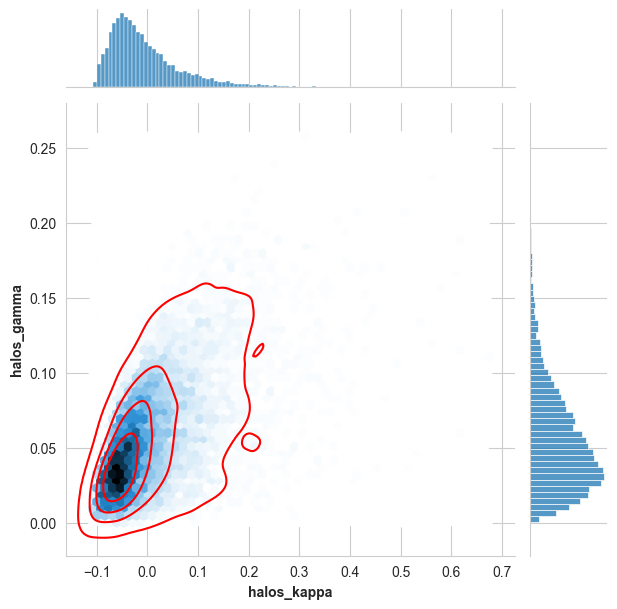

In [17]:
total_plot = sns.jointplot(x=kappa_random_halos, y=gamma_random_halos, kind="hex")
total_plot.plot_joint(sns.kdeplot, color="r", zorder=3, levels=5)
total_plot.ax_joint.set_xlabel("halos_kappa", fontweight="bold")
total_plot.ax_joint.set_ylabel("halos_gamma", fontweight="bold")
plt.show()

## Combine the halos and glass data

In [18]:
current_directory = os.getcwd()
parent_directory = os.path.dirname(current_directory)
slsim_directory = os.path.dirname(parent_directory)
file_path = os.path.join(parent_directory, "tests/TestData/kgdata.npy")

In [19]:
kappa_values, gamma_values, nside = read_glass_data(file_name=file_path)
skyarea = skyarea_form_n(nside)
kappa_random_glass, gamma_random_glass = generate_samples_from_glass(
    kappa_values, gamma_values, n=5000
)
print(kappa_random_glass.shape, gamma_random_glass.shape)

(5000,) (5000,)


In [20]:
total_kappa, total_gamma = halos_plus_glass(
    kappa_random_glass, gamma_random_glass, kappa_random_halos, gamma_random_halos
)

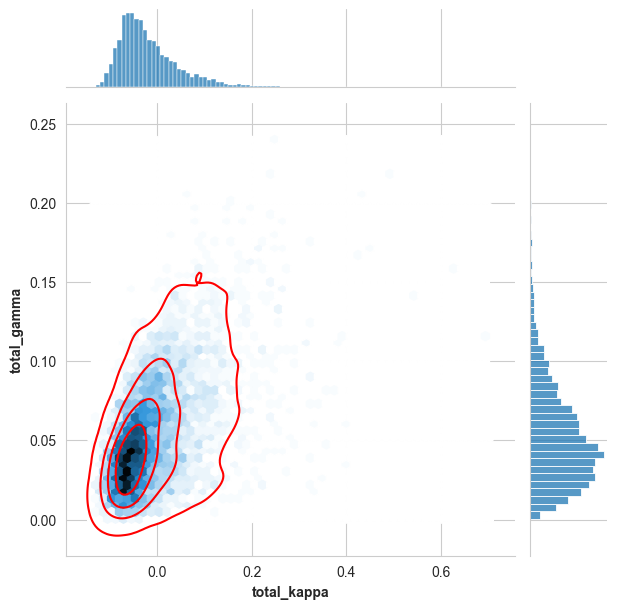

In [21]:
total_plot = sns.jointplot(x=total_kappa, y=total_gamma, kind="hex")
total_plot.plot_joint(sns.kdeplot, color="r", zorder=3, levels=5)
total_plot.ax_joint.set_xlabel("total_kappa", fontweight="bold")
total_plot.ax_joint.set_ylabel("total_gamma", fontweight="bold")
plt.show()

# Plotting the joint distribution of kappa and gamma
## with and without non-linear correction


The 300 halo-lists took 15.580268859863281 seconds to run
zs=1.5, zd=0.5,k_s_mean=-2.225280103052839
The 300 halo-lists took 36.211822271347046 seconds to run
zs=1.5, zd=0.5,k_ext_mean=-2.4520378266756486
Variance of k_S: 0.0023510119535661883
Variance of k_ext: 0.0021550898801612644


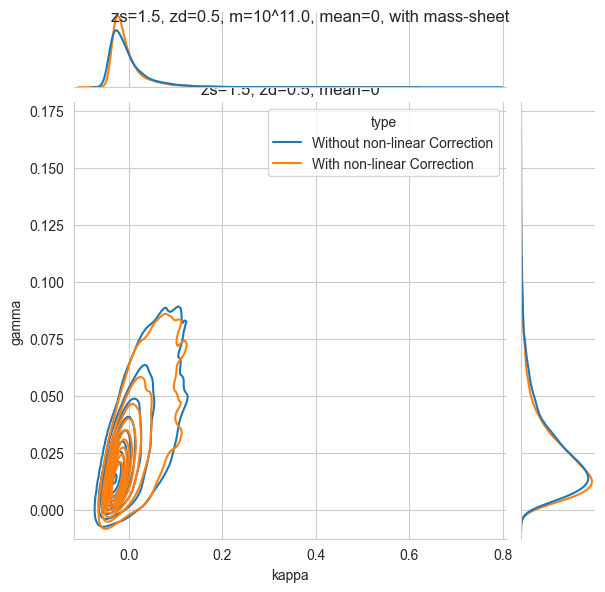

The 300 halo-lists took 28.427757024765015 seconds to run
zs=2.5, zd=0.5,k_s_mean=-3.584609309322467
The 300 halo-lists took 67.9212749004364 seconds to run
zs=2.5, zd=0.5,k_ext_mean=-2.92033930428653
Variance of k_S: 0.01416315278725661
Variance of k_ext: 0.004503933751979193


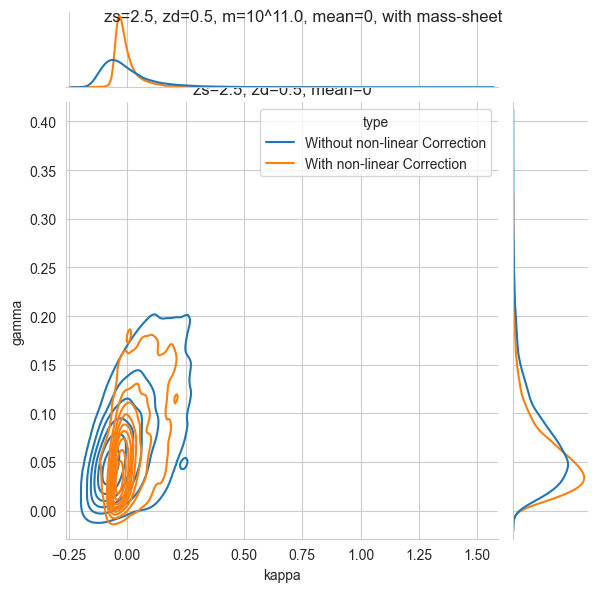

The 300 halo-lists took 10.175448179244995 seconds to run
zs=1.0, zd=0.5,k_s_mean=-1.319350168475219
The 300 halo-lists took 20.512497901916504 seconds to run
zs=1.0, zd=0.5,k_ext_mean=-1.9611706549426098
Variance of k_S: 0.0007758150563361264
Variance of k_ext: 0.0016418753154556374


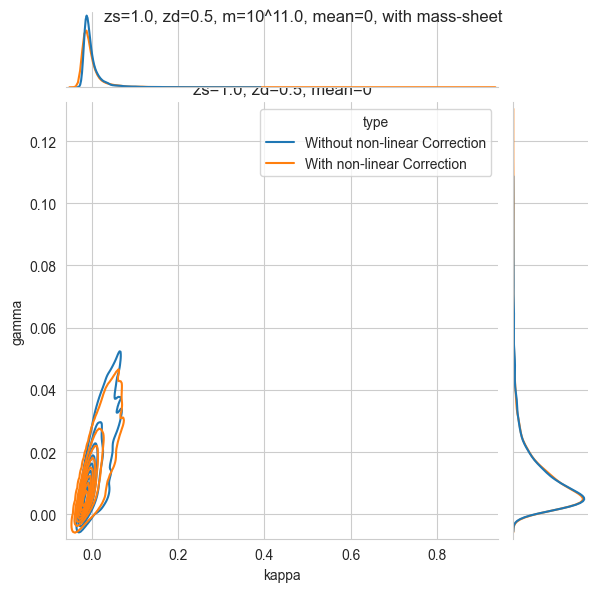

In [22]:
def plot_kappa_gamma(
    zs=1.5,
    zd=0.5,
    n_iterations=300,
    sky_area=0.00036,
    samples_number=30,
    m_min="1.0E+12",
    m_max="1.0E+16",
):
    # Setup Cosmology
    cosmo = default_cosmology.get()
    # Without Correction
    nk, ng = run_halos_without_kde_by_multiprocessing(
        n_iterations=n_iterations,
        sky_area=sky_area,
        samples_number=samples_number,
        cosmo=cosmo,
        m_min=m_min,
        m_max=m_max,
        z_max=zs,
        listmean=False,
    )
    nk_mean = sum(nk) / len(nk)
    print(f"zs={zs}, zd={zd},k_s_mean={nk_mean}")
    nk = convergence_mean_0(nk)

    # With Correction
    distribution = run_certain_redshift_lensext_kde_by_multiprocessing(
        n_iterations=n_iterations,
        sky_area=sky_area,
        samples_number=samples_number,
        cosmo=cosmo,
        m_min=m_min,
        m_max=m_max,
        z_max=zs,
        zs=zs,
        zd=zd,
        listmean=False,
    )
    nk1 = [point[0] for point in distribution]
    ng1 = [point[1] for point in distribution]
    nk1_mean = sum(nk1) / len(nk1)
    print(f"zs={zs}, zd={zd},k_ext_mean={nk1_mean}")
    nk1 = convergence_mean_0(nk1)

    # Combine Data for Joint KDE Plot
    df1 = pd.DataFrame({"x": nk, "y": ng, "type": "Without non-linear Correction"})
    df2 = pd.DataFrame({"x": nk1, "y": ng1, "type": "With non-linear Correction"})
    df_total = pd.concat([df1, df2], axis=0)

    var_nk = np.var(nk)
    var_nk1 = np.var(nk1)
    print(f"Variance of k_S: {var_nk}")
    print(f"Variance of k_ext: {var_nk1}")

    # Plotting
    plot = sns.jointplot(data=df_total, x="x", y="y", hue="type", kind="kde")

    plot.ax_joint.set_xlabel("kappa")
    plot.ax_joint.set_ylabel("gamma")
    m_min_float = float(m_min)
    plt.title(f"zs={zs}, zd={zd}, mean=0")
    plot.fig.suptitle(
        f"zs={zs}, zd={zd}, m=10^{np.log10(m_min_float)}, mean=0, with mass-sheet"
    )
    # plot.ax_joint.set_xlim(-0.2, 0.2)

    plt.show()


# To use the function:
plot_kappa_gamma(zs=1.5, zd=0.5, m_min="1.0E+11", m_max="1.0E+16")
plot_kappa_gamma(zs=2.5, zd=0.5, m_min="1.0E+11", m_max="1.0E+16")
plot_kappa_gamma(zs=1.0, zd=0.5, m_min="1.0E+11", m_max="1.0E+16")